# Advance Streaming

You can do 2 things
* you can apply the aggregations over a time window
* you can trigger actions based on events (State Processing)

**the first one** is easier, and uses the `from pyspark.sql.window import Window`, here we will study its properties and types <br>
**the second one**, requires to track states, this bring OOP to the table and is not as easy as Aggregation Over Windows

## Windows Aggregation

There are 3, we will study the first 2
* Fixed Window: no data overlaping
* Slading Window: data overlaping
* Monitoring Windows: Random windows over the spectrum for analyzing behaivour

### Fixed Window Aggregation over an Event Time
|Image|Description|
|---|---|
|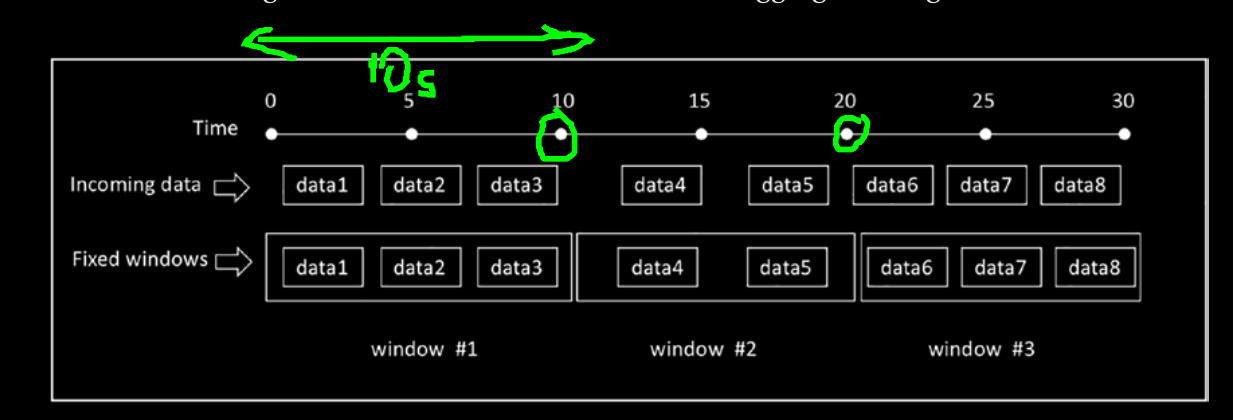|A fixed window (a.k.a. a tumbling window) operation discretizes a stream of incoming data into nonoverlapping buckets based on window length. Each piece of incoming data is placed into one of the buckets based on its event time. |

In [1]:
from pyspark.sql import SparkSession
import os
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("SQL").getOrCreate()

24/07/05 15:33:40 WARN Utils: Your hostname, msi-MAG resolves to a loopback address: 127.0.1.1; using 192.168.0.129 instead (on interface wlp3s0)
24/07/05 15:33:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/05 15:33:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
schema = "`id` String, `action` String, `ts` Timestamp"

StartStreaming

In [3]:
mobile_events = spark.readStream.schema(schema).json("./input/")

Define Streaming Action - > Fixed Window Agg

In [4]:
windCountDF = mobile_events.groupBy(F.window(F.col("ts"),"10 minutes"), F.col("action")).count()

Output (Terminal)

In [6]:
mobileConsoleSQ = windCountDF.writeStream.format("console")\
                    .option("truncate", "false")\
                    .outputMode("complete")\
                    .start()

24/07/05 16:18:23 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-d6e97ddd-a827-4c13-8f26-d6a7858954bf. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/05 16:18:23 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:10:00, 2018-03-02 10:20:00}|open  |2    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|close |6    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|open  |8    |
+------------------------------------------+------+-----+



Stop Output

In [8]:
# stop the streaming query
mobileConsoleSQ.stop()

### Sliding Window Aggregation over Event Time
|||
|---|---|
|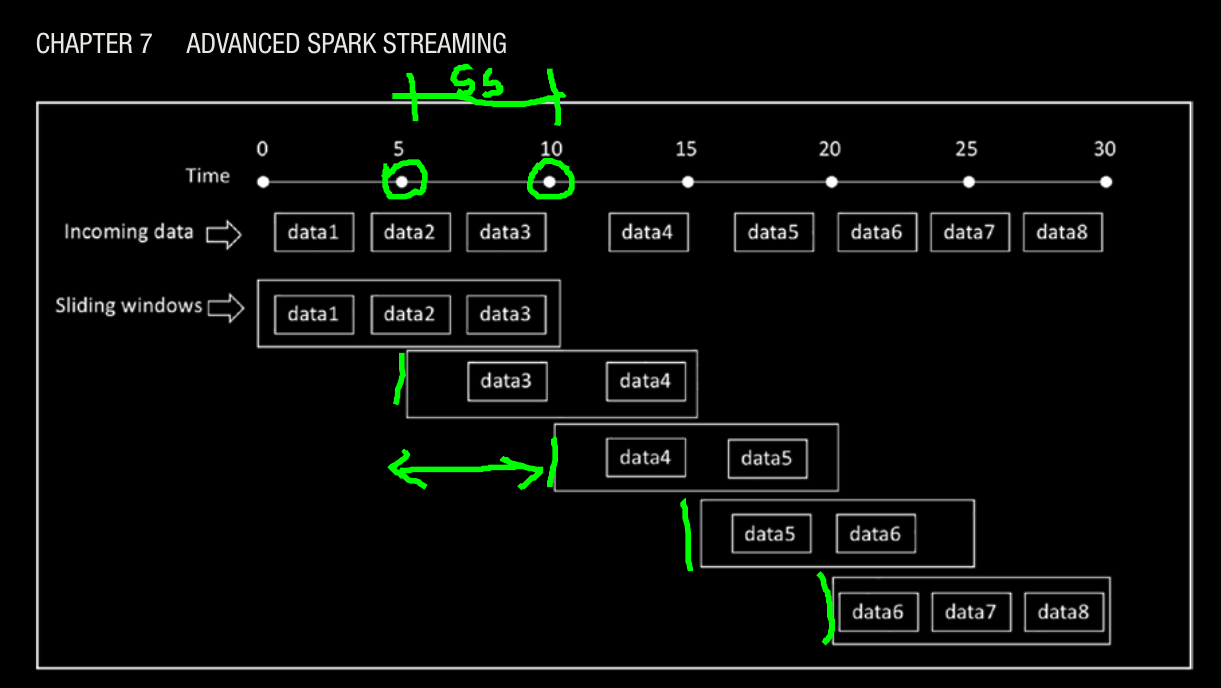|Defining a sliding window requires two pieces of information, the window length and a sliding interval, which is usually smaller than the window length|

Imagine each computer rack emits its temperature at a certain interval. You want to generate a report
about the average temperature among all computer racks and per rack over a window
length of 10 minutes and a sliding interval of 5 minutes

In [9]:
schema = "`rack` String, `temperature` Float, `ts` Timestamp"

Create StreamDataFrame

In [10]:
rack_temperature = spark.readStream.schema(schema).json("./temperatureRacks/")

In [11]:
#check whether is a Streaming DF
rack_temperature.isStreaming

True

CreateAction
> Look at the second parameter in the window, the step, is lesser than the window size

In [12]:
# group by a sliding window and perform average on the temperature column
iotAvgDF = rack_temperature.groupBy(F.window(F.col("ts"), "10 minutes", "5 minutes")).agg(F.avg("temperature").alias("avg_temp"))

> write data into the <mark>MEMORY</mark>

In [13]:
# write the data out to memory sink with query name as iot
iotMemorySQ = iotAvgDF.writeStream.format("memory")\
                        .queryName("iot")\
                        .outputMode("complete")\
                        .start()

24/07/05 16:43:00 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-6347d694-98eb-40bf-83f2-8a7c84551b1f. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/05 16:43:00 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


Look at the `queryName("iot")`

In [15]:
# now you can query the data
# window > start
spark.sql("select * from iot").orderBy("window.start").show(truncate=False)

+------------------------------------------+--------+
|window                                    |avg_temp|
+------------------------------------------+--------+
|{2017-06-02 07:55:00, 2017-06-02 08:05:00}|99.5    |
|{2017-06-02 08:00:00, 2017-06-02 08:10:00}|101.25  |
|{2017-06-02 08:05:00, 2017-06-02 08:15:00}|102.75  |
|{2017-06-02 08:10:00, 2017-06-02 08:20:00}|103.75  |
|{2017-06-02 08:15:00, 2017-06-02 08:25:00}|105.0   |
+------------------------------------------+--------+



In [16]:
iotMemorySQ.stop()

> **Add another column**

In [17]:
iotAvgByRackDF = rack_temperature.groupBy(F.window("ts", "10 minutes", "5 minutes"),"rack").agg(F.avg("temperature").alias("avg_temp"))

In [18]:
iotByRackConsoleSQ = iotAvgByRackDF.writeStream\
                    .format("memory")\
                    .queryName("iot_rack")\
                    .outputMode("complete")\
                    .start()

24/07/05 16:50:11 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-efd5e4d7-8071-4493-a0ec-e81c2aeee57e. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/05 16:50:11 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [19]:
spark.sql("SELECT * FROM iot_rack").orderBy("window.start").show(truncate=False)

+------------------------------------------+-----+--------+
|window                                    |rack |avg_temp|
+------------------------------------------+-----+--------+
|{2017-06-02 07:55:00, 2017-06-02 08:05:00}|rack1|99.5    |
|{2017-06-02 07:55:00, 2017-06-02 08:05:00}|rack2|99.5    |
|{2017-06-02 08:00:00, 2017-06-02 08:10:00}|rack1|100.0   |
|{2017-06-02 08:00:00, 2017-06-02 08:10:00}|rack2|102.5   |
|{2017-06-02 08:05:00, 2017-06-02 08:15:00}|rack2|104.75  |
|{2017-06-02 08:05:00, 2017-06-02 08:15:00}|rack1|100.75  |
|{2017-06-02 08:10:00, 2017-06-02 08:20:00}|rack2|106.0   |
|{2017-06-02 08:10:00, 2017-06-02 08:20:00}|rack1|101.5   |
|{2017-06-02 08:15:00, 2017-06-02 08:25:00}|rack1|102.0   |
|{2017-06-02 08:15:00, 2017-06-02 08:25:00}|rack2|108.0   |
+------------------------------------------+-----+--------+



In [20]:
# stop query stream
iotByRackConsoleSQ.stop()

# Watermarking: 
|Image|Concept|
|----------------------------------|----------------------------------|
|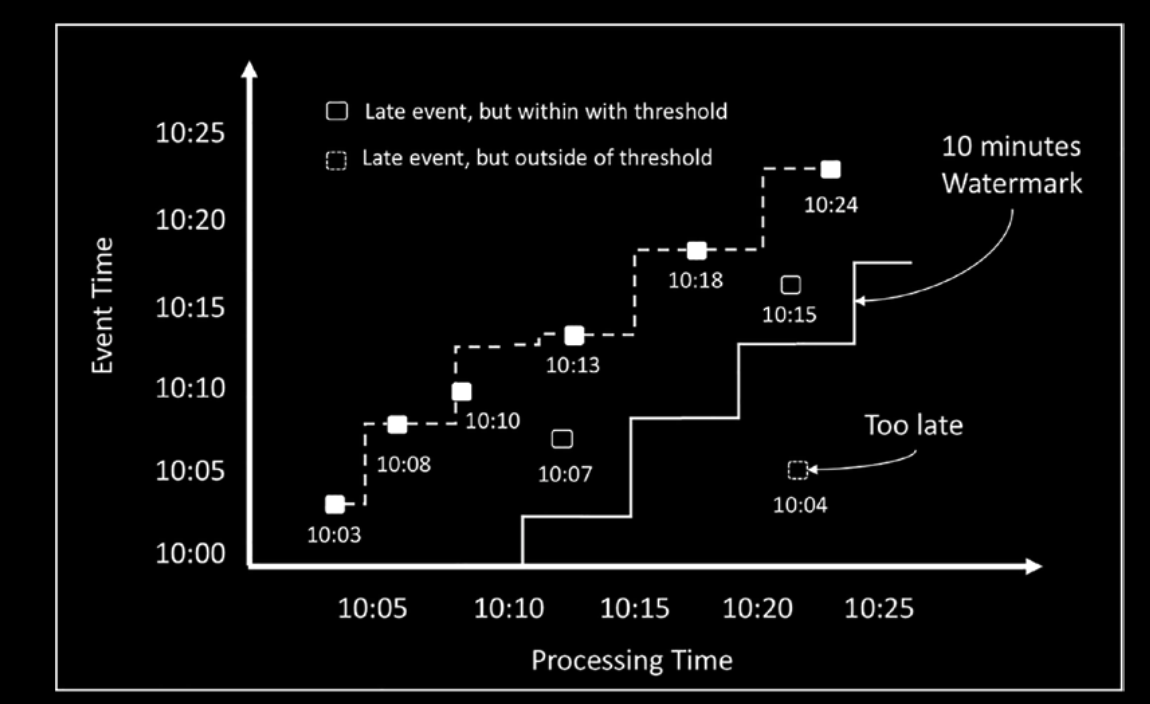|Watermarking can be seens as *tolerance*: if data arrives late, but it does inside a **10 min** delta... is tolerated, hence, aggregations will be recomputed for the interval, **it also sets the rule that after 10 min**, no data will be updated, which means under hood: <mark>this part of the dataset has become static</mark> |

> You just need to provide two pieces of data to the withWatermark
API, the event time column, and the threshold, which can be in seconds, minutes, or
hours. 

Lets create an example 

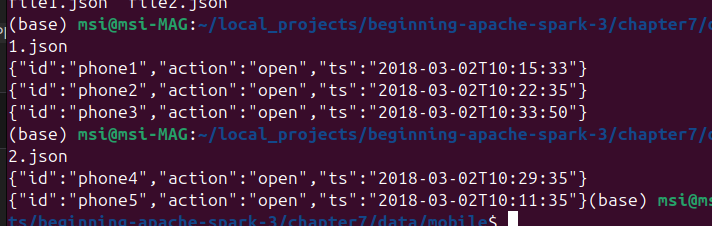

> create a new folder called `mobileStreaming`, to simulate streaming, first copy `file1.json` then `file2.json`

#### Analysis
windows os every 10 min will be generated, means 
* 10:10
* 10:20
* 10:30
This will set the max date from file1.json, `T10:33:50`, to lead the 10 min tolerance, setting the break point at `T10:23:50`

> when copying `file2.json` both values will be out of sync 
* 10:29:35 will arrive inside the 10 min window
* 10:11:35 is out of the break point 

In [22]:
mobileSchema = "`id` String, `action` String, `ts` Timestamp"

In [24]:
mobileSSDF = spark.readStream.schema(mobileSchema).json("watermarking/")

Action + WaterMark

In [25]:
# setup a streaming DataFrame with a watermark and group by ts and action column.
windowCountDF = mobileSSDF.withWatermark("ts", "10 minutes")\
                .groupBy(F.window("ts","10 minutes"), "action").count()

Print OUt in Console

In [26]:
mobileMemorySQ = windowCountDF.writeStream.format("console").option("truncate", "false")\
                .outputMode("update").start()

'''
*The output mode can’t be the complete mode and must be in either
update or append mode

*The event time column specified in the Watermark API and the
groupBy transformation must be the same one.

* When setting up a streaming DataFrame, the Watermark API must be
called before the groupBy transformation; otherwise, it is ignored.
'''

24/07/05 17:22:07 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-a1b93278-35db-49f6-8c16-136a90218cfe. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/05 17:22:07 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


'\n*The output mode can’t be the complete mode and must be in either\nupdate or append mode\n\n*The event time column specified in the Watermark API and the\ngroupBy transformation must be the same one.\n\n* When setting up a streaming DataFrame, the Watermark API must be\ncalled before the groupBy transformation; otherwise, it is ignored.\n'

-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:10:00, 2018-03-02 10:20:00}|open  |1    |
|{2018-03-02 10:20:00, 2018-03-02 10:30:00}|open  |1    |
|{2018-03-02 10:30:00, 2018-03-02 10:40:00}|open  |1    |
+------------------------------------------+------+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+------+------+-----+
|window|action|count|
+------+------+-----+
+------+------+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:20:00, 2018-03-02 10:30

In [28]:
mobileMemorySQ.stop()

# State Processing
|Stateful Processing||
|---|---|
|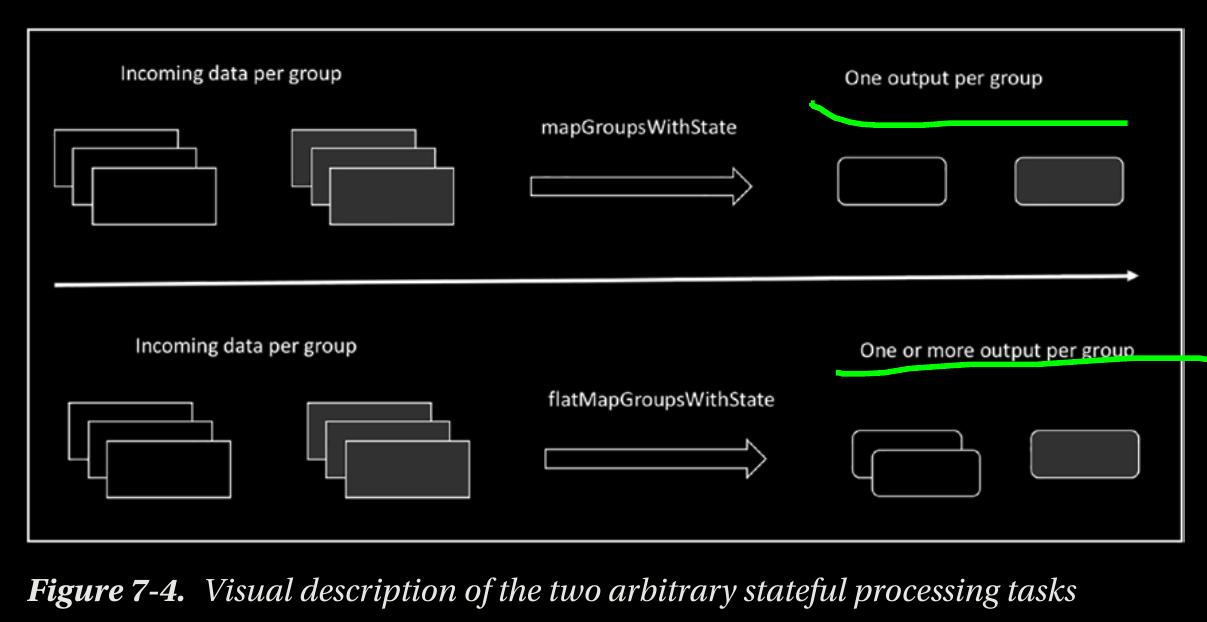|The big difference is the **callback**, whenever new data is receive the system call this function, so if you provide an instance of a class, you will be able to trace states. Talking about callbacks there are 2 types:<br> * **mapGroupsWithState**<br> * **flatMapGroupsWithState**|



### Really good example of stateful streaming
Look at the number of Visit parameter, its State depends upon the previous state
|Image|Example|
|---|---|
|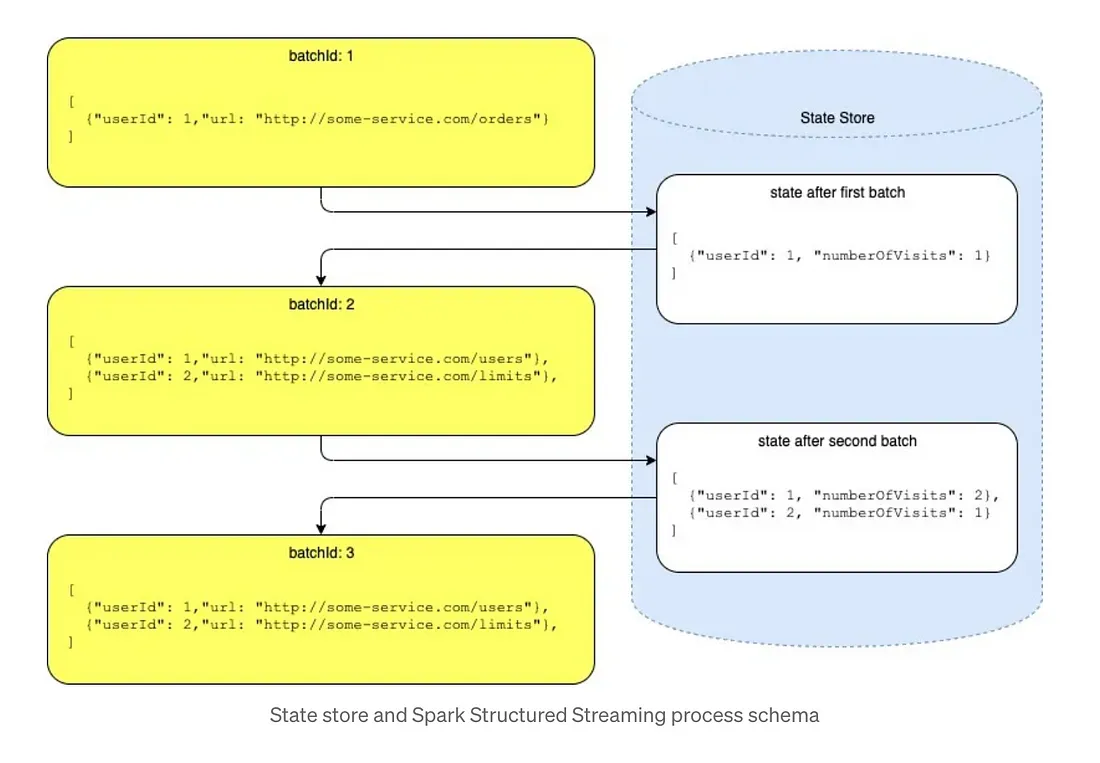|Processing of one stream of data is dependent upon the previous stream of data. So the intermediate result is stored as state. Every time a new stream of data arrives, it reads the state and builds calculation on top of that value and store it in state store.|

## pyspark.sql.GroupedData.applyInPandasWithState¶




seems than equivalent to `mapGroupsWithState` in Scala is `applyInPandasWithState` in Python, <mark>but Python language uses dynamic typing</mark>. **On the other habd**, PySpark `state` only supports storing a tuple that matches with the user-specified schema, on the other hand `applyInPandasWithState` supports only dataframes

> <mark>An approach that merges both is needed</mark>


### Syntaxis
https://www.databricks.com/blog/python-arbitrary-stateful-processing-structured-streaming?source=post_page-----d213d32beef3--------------------------------

### The method to call 
---
```python

df.groupBy(df["..."]).applyInPandasWithState(
    func,
    StructType(...),
    StructType(...),
    "...",
    GroupStateTimeout.NoTimeout
)

# here is the detailed syntax

def applyInPandasWithState(
    self,
    func: Callable,
    # Schema for the output DataFrame.
    outputStructType: Union[pyspark.sql.types.StructType, str],
    # Schema for the state
    stateStructType: Union[pyspark.sql.types.StructType, str], 
    # Output mode such as "Update"
    outputMode: str,
    # Timeout such as "NoTimeout"
    timeoutConf: str,
) -> DataFrame
```

### How does user-defined function `func` looks like
---
pay attention to the type and how you must return an Iterator (yield instead of return)
**Stateful Function**: the `func()` is called, onces per key!
* key: This is a tuple containing the unique key for the current group being processed. (means that the function is called onces per key)
* Col_of_dfs_dataReceived: This is an iterator over the *batches of DataFrames* associated with the current key (so there might be more than 1 df).  
* state: This is an instance of GroupState associated with the current key. (last_state = (value1, value2, ...))

```python
def func(
    # Grouping keys.
    key: Tuple,
    # Iterator of batches for one group.
    Col_of_dfs_dataReceived: Iterator[pandas.DataFrame],
    # State to get and/or update. Identical with Scala API.
    state: pyspark.sql.streaming.state.GroupState
) -> Iterator[pandas.DataFrame]
```


### Simple Example with syntaxis
---

```python
def func(
    key: Tuple, pdfs: Iterator[pd.DataFrame], state: GroupState
) -> Iterator[pd.DataFrame]:
    for pdf in pdfs
        # Do something with `state`.
        s: Tuple = state.get
        state.update((..., ..., ...))
        yield pdf

df.groupBy(df["..."]).applyInPandasWithState(
    func,
    StructType(...),
    StructType(...),
    "...",
    GroupStateTimeout.NoTimeout
)
```



## dataStramingWithState

### Word Counting Example w/o TimeOut

In [46]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from datetime import datetime

# Hard Typed
from typing import Tuple, Iterator
import pandas as pd

# Stateful Streamming
from pyspark.sql.streaming.state import GroupState, GroupStateTimeout


spark = SparkSession.builder.appName("SQL").getOrCreate()

lets use sockets for this example 
|Socket Connection|Lorem Impsu|
|---|---|
|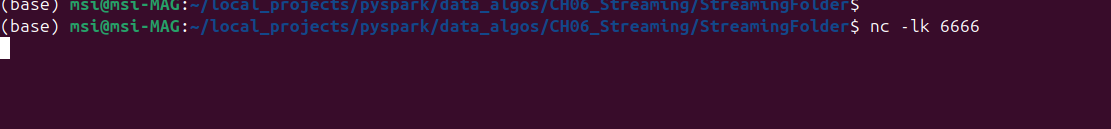|The key will be the word itself, and we neet to count how many of them there are|

In [69]:
# Source 
socketDF = spark.readStream.format("socket")\
        .option("host", "localhost")\
        .option("port", "6666").load()

# action -> explode generates one line per record, the records are a sinlge word generated by split(" ") 
words = socketDF.select(F.explode(F.split(socketDF.value, " ")).alias("words"))

# write Stream -> must be after the func definition
query = words.writeStream.format("console").outputMode("append").start()

24/07/12 11:06:17 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.
24/07/12 11:06:17 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-c7fdd652-86f5-42e8-b406-9d41983db0aa. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/12 11:06:17 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+-----+
|words|
+-----+
+-----+



In [70]:
query.stop()

|Inputs|Task|
|---|---|
|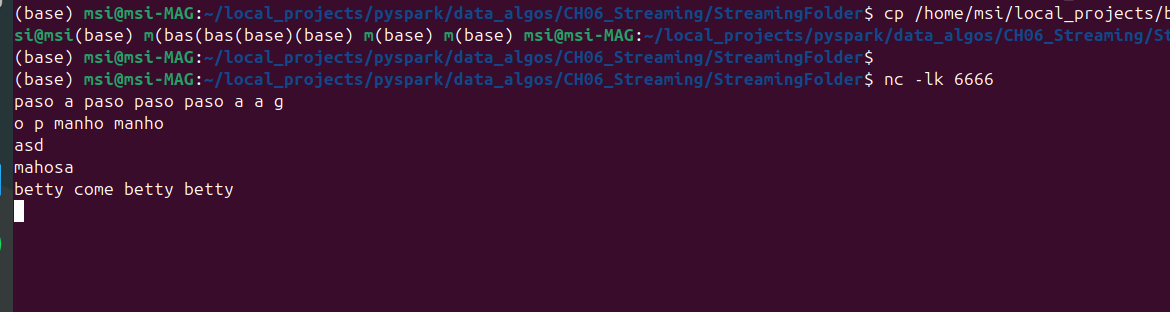| Now the input is working correctly, lets see how to aggregate it |

In [71]:

# Look how key and State are held separately 
def func(key_: Tuple['str'], data_in_cfd: Iterator[pd.DataFrame], lastState:GroupState) -> Iterator[pd.DataFrame]:
    # get State or Initiallize
    if lastState.exists:
        (lastCount,) = lastState.get
    else:
        lastCount = 0
    '''
    Syntax : map(fun, iter)

    Parameters:
        fun: It is a function to which map passes each element of given iterable.
        iter: It is iterable which is to be mapped. 

    Look at the function, len returns number of rows of a single, df, iterate over data_in_cfd
    '''
    # Aggregate the number of words.
    # count_ = sum(map(lambda one_df: len(one_df), data_in_cfd))
    all_rows = pd.concat(data_in_cfd)
    count_ = lastCount + len(all_rows)
    # update State
    lastState.update((count_,))

    yield pd.DataFrame({"words": [key_[0]], "count": [count_]}) 

# Group the data by word, and compute the count of each group
output_schema = "`words` STRING, `count` LONG"
state_schema = "`count` LONG"

sessions = words.groupBy(words["words"]).applyInPandasWithState(
    func,
    output_schema,
    state_schema,
    "append",
    GroupStateTimeout.NoTimeout
)


# Start running the query that prints the windowed word counts to the console.
query = sessions.writeStream.foreachBatch(lambda df, _: df.show()).start()

24/07/12 11:06:45 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-9347a57f-ac18-4d89-a960-ff0085636f40. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/12 11:06:45 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


+-----+-----+
|words|count|
+-----+-----+
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
|     |    1|
|betty|    3|
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
| fool|    2|
|betty|    5|
| adiu|    1|
+-----+-----+



+------+-----+
| words|count|
+------+-----+
| words|    1|
|   the|    1|
|expire|    1|
| never|    1|
|  look|    1|
|      |    2|
+------+-----+



+-----+-----+
|words|count|
+-----+-----+
|betty|    6|
+-----+-----+



In [72]:
query.stop()

|||
|---|---|
|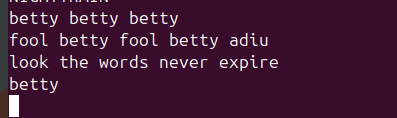|its fascinating<br>Look the word betty, even when no instance of betty was passed on the 3rd phrase, when summon again, betty increases to 6<br>**Estates do not fade out... they are keeped through eternity**<br> enters <mark>TimeOut</mark>|

### Word Counting Example with TimeOut

In [101]:

# Look how key and State are held separately 
def func(key_: Tuple['str'], data_in_cfd: Iterator[pd.DataFrame], lastState:GroupState) -> Iterator[pd.DataFrame]:
    if lastState.hasTimedOut:
        (lastCount,) = lastState.get
        lastState.remove()
        
    else:
        # get State or Initiallize
        if lastState.exists:
            (lastCount,) = lastState.get
        else:
            lastCount = 0
        # Aggregate the number of words.
        # count_ = sum(map(lambda one_df: len(one_df), data_in_cfd))
        all_rows = pd.concat(data_in_cfd)
        count_ = lastCount + len(all_rows)
        # update State
        lastState.update((count_,))
        lastState.setTimeoutDuration(7000) # 7 seconds
        # you must retrun a DF, but you dont want to print now, you want to print only when hasTimedOut=True
        yield pd.DataFrame({"words": [key_[0]], "count": [count_]}) 

# Group the data by word, and compute the count of each group
output_schema = "`words` STRING, `count` LONG"
state_schema = "`count` LONG"

sessions = words.groupBy(words["words"]).applyInPandasWithState(
    func,
    output_schema,
    state_schema,
    "append",
    GroupStateTimeout.ProcessingTimeTimeout
)

# Start running the query that prints the windowed word counts to the console.
query = sessions.writeStream.foreachBatch(lambda df, _: df.show()).start()


24/07/12 12:31:30 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-5f46a9a2-5dfd-4336-83a1-c9c460931cf9. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/12 12:31:30 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


+-----+-----+
|words|count|
+-----+-----+
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
|berry|    1|
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
|funck|    1|
|  the|    1|
| what|    1|
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
+-----+-----+



+-----+-----+
|words|count|
+-----+-----+
+-----+-----+



+-------+-----+
|  words|count|
+-------+-----+
|      5|    1|
|seconds|    1|
|  ptint|    1|
|   rthe|    1|
|   only|    1|
|       |    1|
|  betty|    1|
+-------+-----+



In [103]:
query.stop()

|The input| Output Resets|
|---|---|
|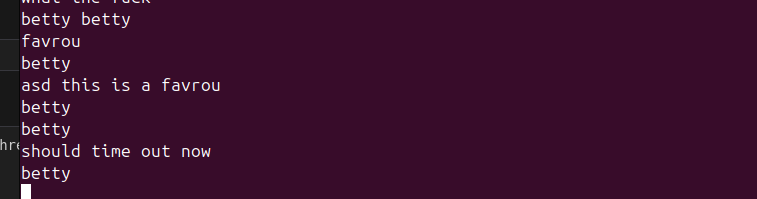|Look how the counter resets, look Betty|

### Trying to not print empty dfs
A task for future Vitto, couldn't find a way to do it, also chatGPT cannot do it

In [81]:
query.stop()

### Rack Temperature Update example
> The pattern of interest is the three consecutive temperature readings of 100 degrees or more from the same rack
> When such a pattern is detected,
the status of that rack is upgraded to a warning status. If the next incoming temperature
reading falls below the 100-degree threshold, the rack status is downgraded to normal.
* file1.json show the temperature over time of rack1
* file2.json show the temperature over time of rack2
* file3.json show the temperature over time of rack3

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
#from dataclasses import dataclass
from datetime import datetime

# Hard Typed
from typing import Tuple, Iterator
import pandas as pd

# Stateful Streamming
from pyspark.sql.streaming.state import GroupState, GroupStateTimeout


spark = SparkSession.builder.appName("SQL").getOrCreate()

# Data Comming In Format
rackSchema = T.StructType([
    T.StructField("rack", T.StringType(), True),
    T.StructField("temperature", T.FloatType(), True),
    T.StructField("ts", T.TimestampType(), True)
])

# State Schema = Output Schema in this case
stateSchema = T.StructType([
    T.StructField("rackId", T.StringType(), True), #this was not necessary but to make 
    T.StructField("highTempCount", T.IntegerType(), True),
    T.StructField("status", T.StringType(), True),
    T.StructField("lastTS", T.TimestampType(), True)
])


# Read streaming data from JSON files in a folder
mobileSSDF = spark.readStream \
    .schema(rackSchema) \
    .json("StreamingFolder/")  # Replace with your folder path containing JSON files



24/07/12 08:39:47 WARN Utils: Your hostname, msi-MAG resolves to a loopback address: 127.0.1.1; using 192.168.0.129 instead (on interface wlp3s0)
24/07/12 08:39:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/12 08:39:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


THis is the data you will deal with

In [44]:
cat /home/msi/local_projects/pyspark/data_algos/CH06_Streaming/temperatureRacks/*

{"rack":"rack1","temperature":99.5,"ts":"2017-06-02T08:01:01"}
{"rack":"rack1","temperature":100.5,"ts":"2017-06-02T08:02:02"}
{"rack":"rack1","temperature":98.3,"ts":"2017-06-02T08:02:29"}
{"rack":"rack1","temperature":102.0,"ts":"2017-06-02T08:02:44"}{"rack":"rack1","temperature":97.5,"ts":"2017-06-02T08:02:59"}
{"rack":"rack2","temperature":99.5,"ts":"2017-06-02T08:03:02"}
{"rack":"rack2","temperature":105.5,"ts":"2017-06-02T08:03:44"}
{"rack":"rack2","temperature":104.0,"ts":"2017-06-02T08:04:06"}
{"rack":"rack2","temperature":108.0,"ts":"2017-06-02T08:04:49"}{"rack":"rack2","temperature":108.0,"ts":"2017-06-02T08:06:40"}
{"rack":"rack3","temperature":100.5,"ts":"2017-06-02T08:06:20"}
{"rack":"rack3","temperature":103.7,"ts":"2017-06-02T08:07:35"}
{"rack":"rack3","temperature":105.3,"ts":"2017-06-02T08:08:53"}

https://medium.com/@swarup.media/arbitrary-stateful-streaming-using-pyspark-d213d32beef3

In [38]:

'''
LOGIC
3 consecutive measures above 100 degrees, and the time
gap between each one and the one before is less than 60 seconds
-> WARNING!
'''
'''
rackState = {highTempCount, status, lastTS}
rackInfo = {rack, temperature, ts}
'''
# Handle Racks individually, and its properties
def updateRackState(rackState, rackInfo):
    # maybe it does have a previous state, but if not, use current TS
    lastTS = rackState.lastTS if rackState.lastTS else rackInfo.ts
    '''2 Con conditions
    is the gap between measures less than 60 seconds? = 60.000 milliseconds
    is T above 100?
    '''
    withinTimeThreshold = (rackInfo.ts.timestamp() - lastTS.timestamp()) <= 60
    greaterThanEqualTo100 = rackInfo.temperature >= 100.0

    '''logic corrector for +60min-> counter comeback to 0 hence withinTimeThreshold=False, 
    but if T>100 hence greaterThanEqualTo100=True
    if you use this 2 variables you get (False AND True) = False, you never enter into the IF
    '''
    meetCondition = True if (rackState.highTempCount < 1) else withinTimeThreshold
    
    
    if greaterThanEqualTo100 and meetCondition:
        # increase counters
        rackState.highTempCount = rackState.highTempCount + 1 # increase counter os the class RackState
        rackState.status = "Warning" if rackState.highTempCount >= 3 else "Normal"
    else:  
        # start over
        rackState.highTempCount = 0  
        rackState.status = "Normal"
    
    rackState.lastTS = rackInfo.ts
    return rackState

# Force Yourself Static typing
def BatchesUpdateRackState(rackId: Tuple[str], df_rackInfo: Iterator[pd.DataFrame], oldState: GroupState) -> Iterator[pd.DataFrame]:
    # get State or Initiallize
    if oldState.exists: 
        (rackId, highTempCount, status, lastTS) = oldState.get
        rackState = pd.Series({'rackId': rackId, 'highTempCount': highTempCount, "status":status, 'lastTS':pd.to_datetime(lastTS)})  
    else:
        rackState = pd.Series({'rackId': rackId[0], 'highTempCount': 0, "status":"Normal", 'lastTS':pd.to_datetime('2000-01-01 00:00:00')})

    
    all_rows = pd.concat(df_rackInfo).sort_values(by='ts')
    for rack_info in all_rows.itertuples(index=False):
        # CONTINUE TO WORK WITH
        rackState = updateRackState(rackState, rack_info)
        oldState.update((rackState.rackId, rackState.highTempCount, rackState.status, rackState.lastTS))
        
    yield pd.DataFrame({'rackId': [rackId[0]], 'highTempCount': [rackState.highTempCount], "status":[rackState.status], 'lastTS':[rackState.lastTS]})
        
# Apply the function using applyInPandasWithState
query = mobileSSDF.groupBy("rack") \
    .applyInPandasWithState(BatchesUpdateRackState,  
                            outputStructType=stateSchema, 
                            stateStructType=stateSchema, 
                            outputMode="append",
                            timeoutConf=GroupStateTimeout.NoTimeout) 

# Output Console
# Start running the query that prints the windowed word counts to the console.
iotPatternSQ = query.writeStream.foreachBatch(lambda df, _: df.show()).start()

24/07/12 09:22:05 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-2ed94b78-2634-475c-ad08-8bf5a85e3fd6. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/07/12 09:22:05 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


/home/msi/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:633: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/home/msi/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:633: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


+------+-------------+-------+-------------------+
|rackId|highTempCount| status|             lastTS|
+------+-------------+-------+-------------------+
| rack1|            0| Normal|2017-06-02 08:02:59|
| rack2|            3|Warning|2017-06-02 08:04:49|
+------+-------------+-------+-------------------+



/home/msi/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:633: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/home/msi/spark-3.4.0-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:633: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


+------+-------------+------+-------------------+
|rackId|highTempCount|status|             lastTS|
+------+-------------+------+-------------------+
| rack3|            1|Normal|2017-06-02 08:08:53|
|     r|            0|Normal|2017-06-02 08:06:40|
+------+-------------+------+-------------------+



In [39]:
iotPatternSQ.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [40]:
iotPatternSQ.lastProgress

{'id': 'b9773ad1-e683-4721-a7a4-523ebf883e7a',
 'runId': '4547ba89-30b0-4013-bdd3-7c2f199d1b09',
 'name': None,
 'timestamp': '2024-07-12T07:24:00.483Z',
 'batchId': 2,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'latestOffset': 0, 'triggerExecution': 0},
 'stateOperators': [{'operatorName': 'applyInPandasWithState',
   'numRowsTotal': 3,
   'numRowsUpdated': 0,
   'allUpdatesTimeMs': 13162,
   'numRowsRemoved': 0,
   'allRemovalsTimeMs': 0,
   'commitTimeMs': 13920,
   'memoryUsedBytes': 82672,
   'numRowsDroppedByWatermark': 0,
   'numShufflePartitions': 200,
   'numStateStoreInstances': 200,
   'customMetrics': {'loadedMapCacheHitCount': 200,
    'loadedMapCacheMissCount': 0,
    'stateOnCurrentVersionSizeBytes': 21520}}],
 'sources': [{'description': 'FileStreamSource[file:/home/msi/local_projects/pyspark/data_algos/CH06_Streaming/StreamingFolder]',
   'startOffset': {'logOffset': 1},
   'endOffset': {'logOffset': 1},
   'latestOf

In [42]:
# stop a streaming query
iotPatternSQ.stop()

### Large TimeOut Example 
**TimeOut** -> 

Also in Python -> The function emits data only when the state times out <br>
so you acumulate values over time...  <br>
* State Initialization and Update:
    * When new data arrives, the else block in the function is executed.
    * The function processes the incoming data (pdfs) and updates the state (state.update(...)).
    * The state timeout is set to 10 seconds (state.setTimeoutDuration(10000)).

* Timeout Mechanism:
    * The state timeout is configured to 10 seconds, meaning if no new data arrives for a key within 10 seconds, the state for that key is considered timed out.
    When the state times out, state.hasTimedOut becomes True.

* Emitting Data:
    * When state.hasTimedOut is True, the function retrieves the accumulated state, emits it as a DataFrame, and then removes the state (state.remove()).

In [39]:
def updateGroupRackState(rackId: Tuple[str], df_Values: Iterator[pd.DataFrame], OldState: GroupState) -> Iterator[pd.DataFrame]:
    #  it means no new data has been received for this key within the specified timeout duration.
    if OldState.hasTimedOut:
        (rackId,) = rackId
        (highTempCount, status, lastTS) = OldState.get
        OldState.remove()
        yield pd.DataFrame({'rackId': [rackId], 'highTempCount': [highTempCount], "status":[status], 'lastTS':[lastTS]})
    else:
        # Use the Inputs values 
        if OldState.exists: 
            OldState = pd.Series(OldState.get, index=['highTempCount', 'status', 'lastTS']) 
        else:
            rackState = pd.Series({'highTempCount': 0, "status":"Normal", 'lastTS':datetime.min})

        # Create one single DataFrames and Sort all rows by timestamp before processing
        all_rows = pd.concat(df_Values).sort_values(by='ts')
        for index, row in all_rows.iterrows():
            rackState = updateRackState(rackState, row)
        
        OldState.update((rackState.highTempCount, rackState.status, rackState.lastTS))
         
        # Set the timeout duration as 10 seconds
        OldState.setTimeoutDuration(10000)
        yield pd.DataFrame()

24/07/11 15:57:58 WARN StateStore: Error running maintenance thread
java.lang.IllegalStateException: SparkEnv not active, cannot do maintenance on StateStores
	at org.apache.spark.sql.execution.streaming.state.StateStore$.doMaintenance(StateStore.scala:600)
	at org.apache.spark.sql.execution.streaming.state.StateStore$.$anonfun$startMaintenanceIfNeeded$1(StateStore.scala:586)
	at org.apache.spark.sql.execution.streaming.state.StateStore$MaintenanceTask$$anon$1.run(StateStore.scala:446)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:539)
	at java.base/java.util.concurrent.FutureTask.runAndReset(FutureTask.java:305)
	at java.base/java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask.run(ScheduledThreadPoolExecutor.java:305)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.

In [35]:
di = pd.Series({'highTempCount': 0, "status":"Normal", 'lastTS':pd.to_datetime('2000-01-01 00:00:00')})

In [34]:
di.lastTS

Timestamp('2024-07-12 15:30:00')

In [36]:

pd.to_datetime(df_.loc[0,'ts']) - pd.to_datetime(di.lastTS)

Timedelta('6362 days 08:08:53')

In [5]:
data_ = [(99.5,"2017-06-02T08:08:53"),(103.1, "2017-06-02T08:07:35"),(101.8 ,"2017-06-02T08:06:20")]

In [6]:
df_ = pd.DataFrame(data_,columns=['temperature','ts'])

In [12]:
for row in df_.itertuples(index=False):
    rack_info = {
        'temperature': row.temperature,
        'ts': row.ts
    }
    print(type(row))
    print(rack_info)

<class 'pandas.core.frame.Pandas'>
{'temperature': 99.5, 'ts': '2017-06-02T08:08:53'}
<class 'pandas.core.frame.Pandas'>
{'temperature': 103.1, 'ts': '2017-06-02T08:07:35'}
<class 'pandas.core.frame.Pandas'>
{'temperature': 101.8, 'ts': '2017-06-02T08:06:20'}


In [10]:
rack_info['temperature']

101.8

In [6]:
a = RackState(1, 5, "", None)

In [7]:
a.highTempCount

5

## switching to Scala


Scala is not supported on notebooks so.... <br>
Switching to normal files

In [106]:
spark.stop()

24/07/12 12:41:29 WARN StateStore: Error running maintenance thread
java.lang.IllegalStateException: SparkEnv not active, cannot do maintenance on StateStores
	at org.apache.spark.sql.execution.streaming.state.StateStore$.doMaintenance(StateStore.scala:600)
	at org.apache.spark.sql.execution.streaming.state.StateStore$.$anonfun$startMaintenanceIfNeeded$1(StateStore.scala:586)
	at org.apache.spark.sql.execution.streaming.state.StateStore$MaintenanceTask$$anon$1.run(StateStore.scala:446)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:539)
	at java.base/java.util.concurrent.FutureTask.runAndReset(FutureTask.java:305)
	at java.base/java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask.run(ScheduledThreadPoolExecutor.java:305)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.